In [1]:
from IPython.display import display

In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm, tqdm_notebook

tqdm.monitor_interval = 0

from itertools import product
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data

Let's load the data from the hard drive first.

In [3]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')
test = pd.read_csv('../readonly/final_project_data/test.csv.gz')

In [4]:
test_block = sales['date_block_num'].iloc[-1] + 1
test['date_block_num'] = test_block
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


# Get a feature matrix

We now need to prepare the features.

In [5]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid = pd.concat([grid, test])

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [6]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(['ID'] + index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [7]:
all_data.head(5)

,ID,date_block_num,item_id,shop_id,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,0.0,12,10297,54,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,0.0,12,10296,54,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,0.0,12,10298,54,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,0.0,12,10300,54,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,0.0,12,10284,54,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


# Train/test split

In [8]:
dates = all_data['date_block_num']

print('Test `date_block_num` is %d' % test_block)

Test `date_block_num` is 34


In [9]:
dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values

# First level models

We need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first.

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the test month.

In [10]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

And the we run *LightGBM*.

In [11]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

Finally, concatenate test predictions to get test meta-features.

In [12]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

### Train meta-features

We need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.

That is, we need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32, 33. Use the same parameters as in above models.

In [13]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

In [14]:
# And here we create 2nd level feeature matrix, init it with zeros first# And he 
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
pbar = tqdm_notebook([27, 28, 29, 30, 31, 32, 33])
for cur_block_num in pbar:
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           We can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    pbar.set_description('{}: Split'.format(cur_block_num))
    _X_train = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    _X_test =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    _y_train = all_data.loc[dates <  cur_block_num, 'target'].values
    _y_test =  all_data.loc[dates == cur_block_num, 'target'].values
    
    pbar.set_description('{}: LR'.format(cur_block_num))
    lr.fit(_X_train.values, _y_train)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr.predict(_X_test.values)
    
    pbar.set_description('{}: LGB'.format(cur_block_num))
    model = lgb.train(lgb_params, lgb.Dataset(_X_train, label=_y_train), 100)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(_X_test)

Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below.

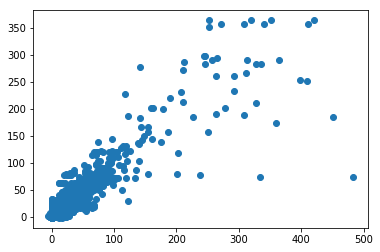

In [15]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that we need to use train meta-features (not test) when searching for $\alpha$.

In [16]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = np.array([r2_score(y_train_level2, np.dot(X_train_level2, [alpha, 1 - alpha])) for alpha in alphas_to_try])
best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.298000; Corresponding r2 score on train: 0.266232


Now use the $\alpha$ we've found to compute predictions for the test set

In [17]:
test_preds = best_alpha * pred_lr + (1 - best_alpha) * pred_lgb
test['item_cnt_month'] = test_preds
test[['ID', 'item_cnt_month']].to_csv('submission_averaging.csv', index=False)

### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [18]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Compute R-squared on the train and test sets.

In [19]:
train_preds = lr.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = lr.predict(np.vstack((pred_lr, pred_lgb)).T)
test['item_cnt_month'] = test_preds
test[['ID', 'item_cnt_month']].to_csv('submission_stacking.csv', index=False)

print('Train R-squared for stacking is %f' % r2_train_stacking)

Train R-squared for stacking is 0.269972
